## Test a Gyro GP relation in PyStan

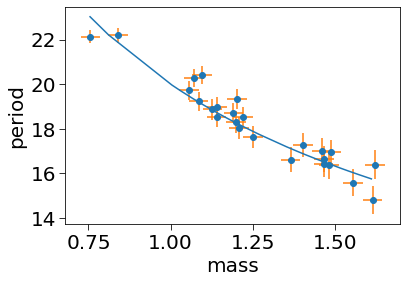

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

npts = 25
mass_true = np.sort(np.random.randn(npts) * 0.2 + 1.2)
period_true = 2.0 * 10**1.0 * mass_true**-0.5

sigma_p = mass_true * 0.4
period_obs = period_true + np.random.randn(npts) * sigma_p

sigma_m = .03
mass_obs = mass_true + np.random.randn(npts) * sigma_m

fig, ax = plt.subplots()
ax.plot(mass_true, period_true)
ax.scatter(mass_obs, period_obs,zorder=1)
ax.errorbar(mass_obs, period_obs, yerr=sigma_p, xerr=sigma_m, fmt='|',zorder=0)
ax.set_xlabel('mass')
ax.set_ylabel('period')
plt.show()

In [8]:
from scipy import stats
slope, intercept, _, _, _ = stats.linregress(mass_obs, period_obs)
slope, intercept


(-7.964163022533426, 28.23338240047366)

In [9]:
gpfit = '''
data {
    int<lower=1> N;
    real M[N];
    vector[N] P;
    real sigma_p[N];
    real sigma_m[N];
}
transformed data{
    real delta = 1e-9;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> rho;
    real m0;
    real c0;
    vector[N] eta;
    real M_true[N];
}
transformed parameters{
    vector[N] f;
    {
        vector[N] mu;
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(M_true, alpha, rho);
        
        // diagonal elements
        for (n in 1:N){
            K[n, n] = K[n, n] + delta;
            mu[n] = m0 * M[n] + c0;
        }
        
        L_K = cholesky_decompose(K);
        f = mu + L_K * eta;
    }
}
model {
    rho ~ inv_gamma(5, 5);
    alpha ~ std_normal();
    eta ~ std_normal();
    
    m0 ~ normal(-10, 3);
    c0 ~ normal(25, 10);
    
    M ~ normal(M_true, sigma_m);
    P ~ normal(f, sigma_p);
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_c989b0d241b94057db6a13df83b606d9 NOW.


In [11]:
data = {'N' : len(mass_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'M' : mass_obs,
       'sigma_m' : sigma_m*np.ones(len(mass_obs))}
init = {'alpha' : 0.4,
        'rho' : 1.,
         'm0' : slope,
         'c0' : intercept,
         'M_true' : mass_true,
         'f' : period_true}

In [12]:
fit = sm.sampling(data=data, iter=10000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [13]:
print(fit)

Inference for Stan model: gpfit_c989b0d241b94057db6a13df83b606d9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        0.74    0.01   0.58   0.03    0.3   0.62   1.06   2.11   2844    1.0
rho          1.28  6.8e-3   0.74    0.5   0.82    1.1   1.51   3.19  11989    1.0
m0          -8.25    0.02   0.86 -10.06  -8.68  -8.25  -7.81  -6.46   2888    1.0
c0          28.71    0.02   1.27  26.21  28.02  28.64  29.32  31.59   3345    1.0
eta[1]      -0.08 10.0e-3   0.98   -2.0  -0.74  -0.07   0.57   1.81   9532    1.0
eta[2]      -0.08  9.6e-3   0.96  -1.96  -0.73  -0.09   0.56   1.84  10107    1.0
eta[3]        0.1  7.3e-3   0.97  -1.81  -0.56   0.09   0.75   1.99  17849    1.0
eta[4]       0.05  7.5e-3   0.99  -1.94  -0.61   0.05   0.74   1.98  17349    1.0
eta[5]    -4.6e-3  7.1e-3    1.0  -1.97  -0.68-2.5e-3   0.67   1.95  19679  

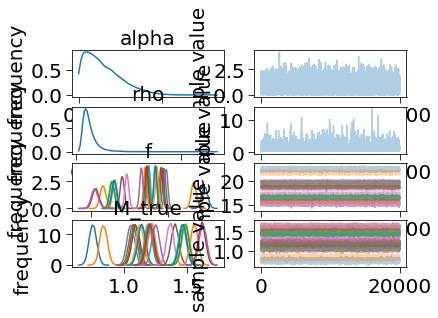

In [14]:
fit.plot(pars=['alpha','rho','f','M_true'])
plt.show()

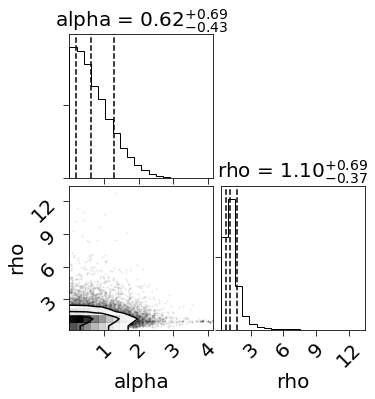

In [15]:
import corner
labels=['alpha','rho']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

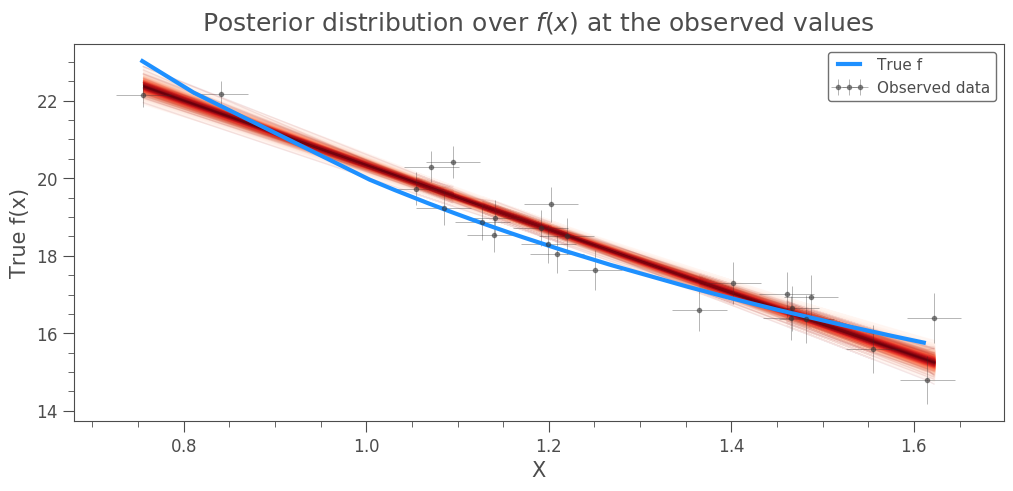

In [17]:
import mystyle
with plt.style.context(mystyle.ms):
    fig = plt.figure(figsize=(12,5)); ax = fig.gca()

    from pymc3.gp.util import plot_gp_dist
    plot_gp_dist(ax, fit["f"], mass_obs);

    # plot the data and the true latent function
    plt.plot(mass_true, period_true, "dodgerblue", lw=3, label="True f");
    plt.errorbar(mass_obs, period_obs, yerr=sigma_p, xerr=sigma_m, fmt='o', ms=3, alpha=0.5, label="Observed data");

    # axis labels and title
    plt.xlabel("X"); plt.ylabel("True f(x)");
    plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();